In [2]:
import io
import requests
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable
import ipywidgets as widgets
import scipy
from scipy import special
import time
from scipy.signal import convolve as conv
import matplotlib.patches as mpatches

plt.style.use(plt.style.available[20])
plt.style.use("https://github.com/comp-neural-circuits/intro-to-comp-neuro/raw/dev/plots_style.txt")

In [3]:
def epsilon_greedy(q, epsilon):
    """Epsilon-greedy policy: selects the maximum value action with probabilty
    (1-epsilon) and selects randomly with epsilon probability.

    Args:
    q (ndarray): an array of action values
    epsilon (float): probability of selecting an action randomly

    Returns:
    int: the chosen action
    """
    if np.random.random() > epsilon:
        action = np.argmax(q)
    else:
        action = np.random.choice(len(q))

    return action


class CliffWorld:
    """
    World: Cliff world.
    40 states (4-by-10 grid world).
    The mapping from state to the grids are as follows:
    30 31 32 ... 39
    20 21 22 ... 29
    10 11 12 ... 19
    0  1  2  ...  9
    0 is the starting state (S) and 9 is the goal state (G).
    Actions 0, 1, 2, 3 correspond to right, up, left, down.
    Moving anywhere from state 9 (goal state) will end the session.
    Taking action down at state 11-18 will go back to state 0 and incur a
      reward of -100.
    Landing in any states other than the goal state will incur a reward of -1.
    Going towards the border when already at the border will stay in the same
      place.
    """
    def __init__(self):
        self.name = "cliff_world"
        self.n_states = 40
        self.n_actions = 4
        self.dim_x = 10
        self.dim_y = 4
        self.init_state = 0

    def get_outcome(self, state, action):
        if state == 9:  # goal state
            reward = 0
            next_state = None
            return next_state, reward
        reward = -1  # default reward value
        if action == 0:  # move right
            next_state = state + 1
            if state % 10 == 9:  # right border
                next_state = state
            elif state == 0:  # start state (next state is cliff)
                next_state = None
                reward = -100
        elif action == 1:  # move up
            next_state = state + 10
            if state >= 30:  # top border
                next_state = state
        elif action == 2:  # move left
            next_state = state - 1
            if state % 10 == 0:  # left border
                next_state = state
        elif action == 3:  # move down
            next_state = state - 10
            if state >= 11 and state <= 18:  # next is cliff
                next_state = None
                reward = -100
            elif state <= 9:  # bottom border
                next_state = state
        else:
            print("Action must be between 0 and 3.")
            next_state = None
            reward = None
        return int(next_state) if next_state is not None else None, reward

    def get_all_outcomes(self):
        outcomes = {}
        for state in range(self.n_states):
            for action in range(self.n_actions):
                next_state, reward = self.get_outcome(state, action)
                outcomes[state, action] = [(1, next_state, reward)]
        return outcomes


def learn_environment(env, learning_rule, params, max_steps, n_episodes):
    # Start with a uniform value function
    value = np.ones((env.n_states, env.n_actions))

    # Run learning
    reward_sums = np.zeros(n_episodes)

    # Loop over episodes
    for episode in range(n_episodes):
        state = env.init_state  # initialize state
        reward_sum = 0

        for t in range(max_steps):
            # choose next action
            action = epsilon_greedy(value[state], params['epsilon'])

            # observe outcome of action on environment
            next_state, reward = env.get_outcome(state, action)

            # update value function
            value = learning_rule(state, action, reward, next_state, value, params)

            # sum rewards obtained
            reward_sum += reward

            if next_state is None:
                break  # episode ends
            state = next_state

        reward_sums[episode] = reward_sum

    return value, reward_sums

In [4]:
def plot_state_action_values(env, value, ax=None):
    """
    Generate plot showing value of each action at each state.
    """
    if ax is None:
        fig, ax = plt.subplots()

    for a in range(env.n_actions):
        ax.plot(range(env.n_states), value[:, a], marker='o', linestyle='--')
    ax.set(xlabel='States', ylabel='Values')
    ax.legend(['R','U','L','D'], loc='lower right')


def plot_quiver_max_action(env, value, ax=None):
    """
        Generate plot showing action of maximum value or maximum probability at
        each state (not for n-armed bandit or cheese_world).
    """
    if ax is None:
        fig, ax = plt.subplots()

    X = np.tile(np.arange(env.dim_x), [env.dim_y,1]) + 0.5
    Y = np.tile(np.arange(env.dim_y)[::-1][:,np.newaxis], [1,env.dim_x]) + 0.5
    which_max = np.reshape(value.argmax(axis=1), (env.dim_y,env.dim_x))
    which_max = which_max[::-1,:]
    U = np.zeros(X.shape)
    V = np.zeros(X.shape)
    U[which_max == 0] = 1
    V[which_max == 1] = 1
    U[which_max == 2] = -1
    V[which_max == 3] = -1

    ax.quiver(X, Y, U, V)
    ax.set(
      title='Maximum value/probability actions',
      xlim=[-0.5, env.dim_x+0.5],
      ylim=[-0.5, env.dim_y+0.5],
    )
    ax.set_xticks(np.linspace(0.5, env.dim_x-0.5, num=env.dim_x))
    ax.set_xticklabels(["%d" % x for x in np.arange(env.dim_x)])
    ax.set_xticks(np.arange(env.dim_x+1), minor=True)
    ax.set_yticks(np.linspace(0.5, env.dim_y-0.5, num=env.dim_y))
    ax.set_yticklabels(["%d" % y for y in np.arange(0, env.dim_y*env.dim_x,
                                                  env.dim_x)])
    ax.set_yticks(np.arange(env.dim_y+1), minor=True)
    ax.grid(which='minor',linestyle='-')


def plot_heatmap_max_val(env, value, ax=None):
    """
    Generate heatmap showing maximum value at each state
    """
    if ax is None:
        fig, ax = plt.subplots()
    
    if value.ndim == 1:
        value_max = np.reshape(value, (env.dim_y,env.dim_x))
    else:
        value_max = np.reshape(value.max(axis=1), (env.dim_y,env.dim_x))
    value_max = value_max[::-1,:]

    im = ax.imshow(value_max, aspect='auto', interpolation='none', cmap='afmhot')
    ax.set(title='Maximum value per state')
    ax.set_xticks(np.linspace(0, env.dim_x-1, num=env.dim_x))
    ax.set_xticklabels(["%d" % x for x in np.arange(env.dim_x)])
    ax.set_yticks(np.linspace(0, env.dim_y-1, num=env.dim_y))
    if env.name != 'windy_cliff_grid':
        ax.set_yticklabels(
          ["%d" % y for y in np.arange(
              0, env.dim_y*env.dim_x, env.dim_x)][::-1])
    return im


def plot_rewards(n_episodes, rewards, average_range=10, ax=None):
    """
    Generate plot showing total reward accumulated in each episode.
    """
    if ax is None:
        fig, ax = plt.subplots()

    smoothed_rewards = (conv(rewards, np.ones(average_range), mode='same')
                      / average_range)

    ax.plot(range(0, n_episodes, average_range),
          smoothed_rewards[0:n_episodes:average_range],
          marker='o', linestyle='--')
    ax.set(xlabel='Episodes', ylabel='Total reward')


def plot_performance(env, value, reward_sums):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
    plot_state_action_values(env, value, ax=axes[0,0])
    plot_quiver_max_action(env, value, ax=axes[0,1])
    plot_rewards(n_episodes, reward_sums, ax=axes[1,0])
    im = plot_heatmap_max_val(env, value, ax=axes[1,1])
    fig.colorbar(im)


C:\Users\sebas\AppData\Local\Temp\ipykernel_26536\38803597.py:96: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(im)


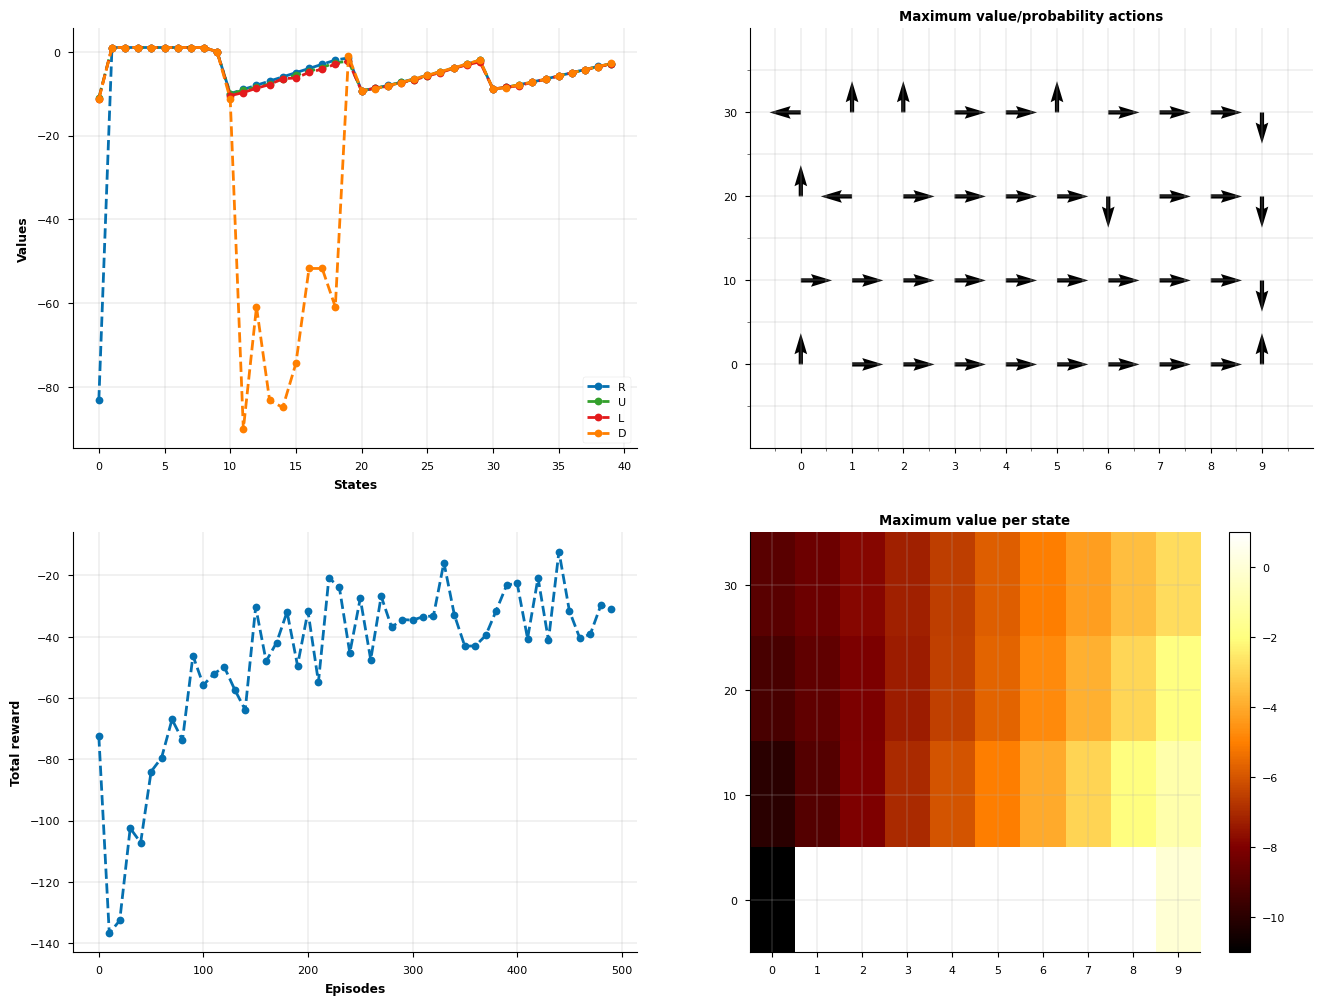

In [5]:


def q_learning(state, action, reward, next_state, value, params):
    """Q-learning: updates the value function and returns it.
    Args:
        state (int): the current state identifier
        action (int): the action taken
        reward (float): the reward received
        next_state (int): the transitioned to state identifier
        value (ndarray): current value function of shape (n_states, n_actions)
        params (dict): a dictionary containing the default parameters
    Returns:
        ndarray: the updated value function of shape (n_states, n_actions)
    """
    # Q-value of current state-action pair
    q = value[state, action]

    # write an expression for finding the maximum Q-value at the current state
    if next_state is None:
        max_next_q = 0
    else:
        max_next_q = np.max(value[next_state])

    # write the expression to compute the TD error
    td_error = reward + params['gamma'] * max_next_q - q
    # write the expression that updates the Q-value for the state-action pair
    value[state, action] = q + params['alpha'] * td_error

    return value


# set for reproducibility, comment out / change seed value for different results
np.random.seed(1)

# parameters needed by our policy and learning rule
params = {
  'epsilon': 0.1,  # epsilon-greedy policy
  'alpha': 0.1,  # learning rate
  'gamma': 1.0,  # discount factor
}

# episodes/trials
n_episodes = 500
max_steps = 1000

# environment initialization
env = CliffWorld()

# solve Cliff World using Q-learning
results = learn_environment(env, q_learning, params, max_steps, n_episodes)
value_qlearning, reward_sums_qlearning = results

# Plot results
plot_performance(env, value_qlearning, reward_sums_qlearning)

<AxesSubplot:>

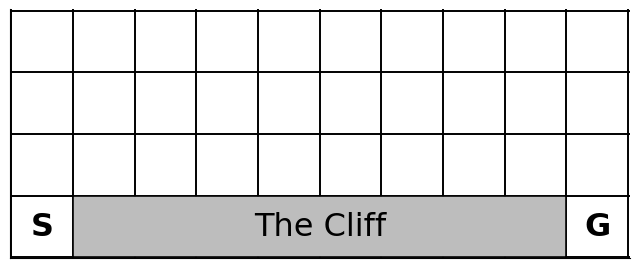

In [6]:
def show_grid_world(ax=None):
    if ax == None:
        fig, ax = plt.subplots(figsize=(8,6))



    ax.grid(linewidth = 1.4, c='k')
    ax.set(
        xticks = [0.5+ii for ii in range(-1,10)],
        yticks = [0.5 + ii for ii in range(-1,4)],
        xlim=[-0.52,9.53],
        ylim = [-0.51,3.52])


    ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    ax.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelleft=False) # labels along the bottom edge are off

    ax.set_aspect('equal', adjustable='box')
    rect=mpatches.Rectangle((0.52,-0.47),7.96,0.95, 
                            fill=True,
                            color="#bdbdbd",zorder=10)
    ax.add_patch(rect)

    ax.annotate('S',(0,0), fontweight='bold',fontsize=23,ha='center',va='center')
    ax.annotate('G',(9,0), fontweight='bold',fontsize=23,ha='center',va='center')
    ax.annotate('The Cliff',(4.5,0), fontsize=23,ha='center',va='center',zorder=12)
    return ax
show_grid_world()

<IPython.core.display.Javascript object>


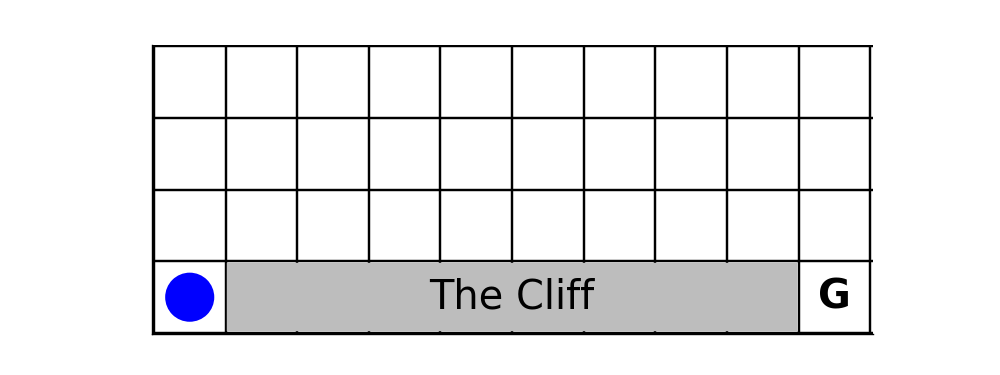

interactive(children=(IntSlider(value=19, description='state', max=39), Output()), _dom_classes=('widget-inter…

In [9]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(8,3))
show_grid_world(ax)
agent = ax.scatter([0],[0],s=800,c='b',zorder=60)

def move_states(state, agent):
    print ([state%10,state//10])
    agent.set_offsets([state%10,state//10])

widgets.interactive(move_states, state = (0,39,1), agent=widgets.fixed(agent))

<IPython.core.display.Javascript object>


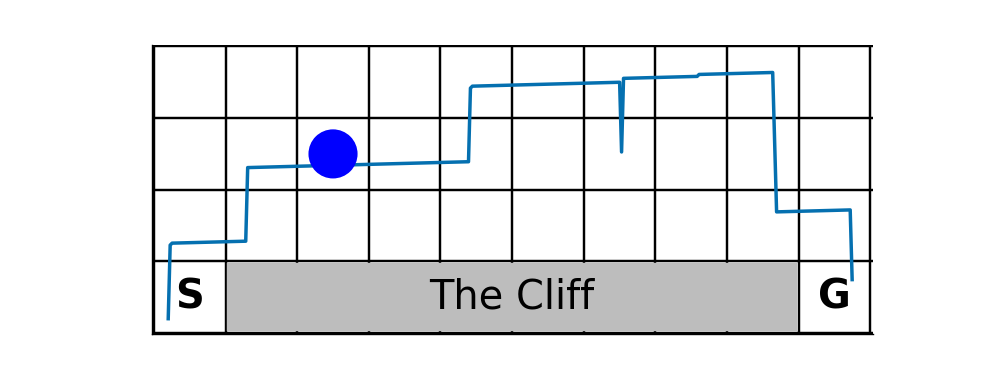

interactive(children=(IntSlider(value=0, description='episode', max=499), IntSlider(value=0, description='move…

In [19]:
fig, ax = plt.subplots(figsize=(8,3))
show_grid_world(ax)
agent = ax.scatter([0],[0],s=800,c='b',zorder=60)
positions = ax.plot([0],[0])[0]


def learn_environment(env, learning_rule, params, max_steps, n_episodes):
    # Start with a uniform value function
    value = np.ones((env.n_states, env.n_actions))

    # Run learning
    reward_sums = np.zeros(n_episodes)
    
    all_states = []
    all_actions = []
    
    
    # Loop over episodes
    for episode in range(n_episodes):
        state = env.init_state  # initialize state
        reward_sum = 0
        
        all_states.append([state])
        all_actions.append([])
        

        for t in range(max_steps):
            # choose next action
            action = epsilon_greedy(value[state], params['epsilon'])
            all_actions[-1].append(action)
            # observe outcome of action on environment
            next_state, reward = env.get_outcome(state, action)
            all_states[-1].append(next_state)

            # update value function
            value = learning_rule(state, action, reward, next_state, value, params)

            # sum rewards obtained
            reward_sum += reward

            if next_state is None:
                break  # episode ends
            state = next_state

        reward_sums[episode] = reward_sum
        
    return all_states, all_actions

params = {
  'epsilon': 0.1,  # epsilon-greedy policy
  'alpha': 0.1,  # learning rate
  'gamma': 1.0,  # discount factor
}

# episodes/trials
n_episodes = 500
max_steps = 1000

# environment initialization
env = CliffWorld()

# solve Cliff World using Q-learning
results = learn_environment(env, q_learning, params, max_steps, n_episodes)
# value_qlearning, reward_sums_qlearning = results
all_states, all_actions = results


def visualise_agent_movements(episode=0, move_number=0):
    
    states_of_episode = all_states[episode]
    actions_of_episode = all_actions[episode] + [0]
    
    move_index = min([move_number,len(states_of_episode)-1])
    
    state = states_of_episode[move_index]
    if state == None:
        agent.set_offsets([4.5,0])
    else:
        agent.set_offsets([state%10,state//10])
    x = [state%10 - 0.3 + 0.6*ii/(len(states_of_episode)) for ii, state in enumerate(states_of_episode) if state != None]
    y = [state//10 - 0.3 + 0.6*ii/(len(states_of_episode)) for ii, state in enumerate(states_of_episode) if state != None]
    positions.set_xdata(x)
    positions.set_ydata(y)

    
widgets.interactive(visualise_agent_movements, episode=(0,n_episodes-1,1),move_number=(0,200,1))
